# Introduction to Computer Vision

## Session 3: Deep Learning for Computer Vision (3 hours)

In [24]:
import os
import warnings
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input as resnet50_preprocess_input,
    decode_predictions as resnet50_decode_predictions,
)
from tensorflow.keras.applications.vgg16 import (
    VGG16,
    preprocess_input as vgg16_preprocess_input,
    decode_predictions as vgg16_decode_predictions,
)
from keras.applications.vgg16 import preprocess_input

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Flatten, Dense,
)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array, load_img,
)
from plot_layers import (
    plot_layer_outputs, imshow,
)

warnings.simplefilter("ignore")
%matplotlib inline

### Introduction to (CNN): Classification

#### Image Augumentation

In [2]:
LOCAL_DATA_PATH = os.path.join(os.path.abspath(''), 'data', 'images', 'classification')

In [3]:
# Generate new images using; stretching, zooming, shrinking, rotating, flipping
# The above step is needed to generalize the learning of model.
ROTATE_ANGLE = 45 # Random rotation between 0 and 45
SHIFT_RANGE = 0.2 # % shift

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=ROTATE_ANGLE,
    width_shift_range=SHIFT_RANGE,
    height_shift_range=SHIFT_RANGE,
    shear_range=SHIFT_RANGE,
    zoom_range=SHIFT_RANGE,
    horizontal_flip=True,
    fill_mode='reflect'
)

# No need Generate new images for test data; all we need is scaling.
test_datagen = ImageDataGenerator(rescale=1/255.)

In [4]:
# Load images from `Train` and `Test` Folders.
TARGET_SIZE = (128, 128)  # resize the image to the given shape.
BATCH_SIZE = 64 # do the image generation as a batch of given batch size.
CLASS_MODE = 'categorical'  # 'categorical' for multiclass; 'binary' for binomial problems
NO_OF_CHANNELS = 3 # number of channels in the images

In [5]:
training_set = train_datagen.flow_from_directory(
    os.path.join(LOCAL_DATA_PATH, 'flowers', 'Train'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

Found 2736 images belonging to 5 classes.


In [6]:
test_set = test_datagen.flow_from_directory(
    os.path.join(LOCAL_DATA_PATH, 'flowers', 'Test'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

Found 934 images belonging to 5 classes.


### Define the ML Classifier model

In [7]:
model = Sequential()  # we are using Sequential api as opposed to Functional api.
# while both can define the same model; functional api give mode flexibility.
# For now that is not needed for us.
first_layer = Conv2D(
    filters=16,  # number of kernels
    kernel_size=(3, 3),  # size of each kernel
    input_shape=(*training_set.target_size, NO_OF_CHANNELS),  # shape of the input image
    activation ='relu', # Activation function for this layer
)
model.add(first_layer)

# Each convolution layer is generally followed by a Pooling layer.
# pool_size=2x2 will bring down the convolution layer output size by half
first_pooling_layer = MaxPooling2D(
    pool_size=(2, 2)
)
model.add(first_pooling_layer)


# 2nd layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the convolution output to get a single layer
model.add(Flatten())


# Add the Neural network for learning from the image feature.
model.add(Dense(units=128, activation='relu'))

# output layer
model.add(Dense(
    units=training_set.num_classes,  # the number of classes in Train data.
    activation='softmax'  # multiclass 
))

Metal device set to: Apple M2 Max


2024-02-08 07:19:15.746120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-08 07:19:15.746270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [9]:
# compile the model
model.compile(
    optimizer='adam', # 'adam' optimizer to minimize the loss for cross entropy
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
training_steps = training_set.samples // 130  # 130 an arbitrary number (around 20 steps)
validations_steps = test_set.samples // 130  # around 7 steps
epochs = 1  # how many training epochs to run.

model.fit_generator(
    training_set,
    steps_per_epoch=training_steps,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=validations_steps
)

2024-02-08 07:19:16.081562: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-08 07:19:16.214219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.3072

2024-02-08 07:19:20.133806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 5s 205ms/step - loss: 1.4830 - accuracy: 0.3072 - val_loss: 1.4142 - val_accuracy: 0.3929


1/1 [==============================] - 0s 74ms/step


2024-02-08 07:19:20.714969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


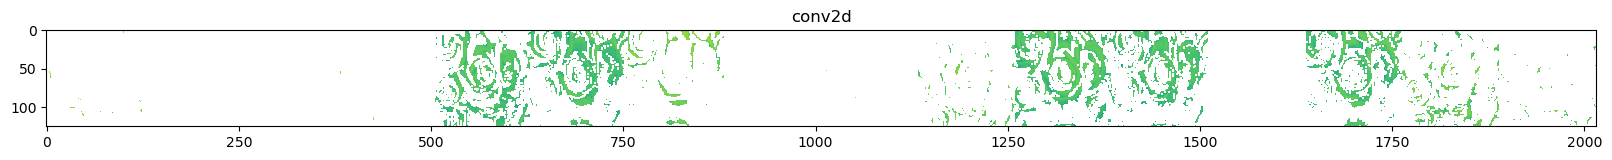

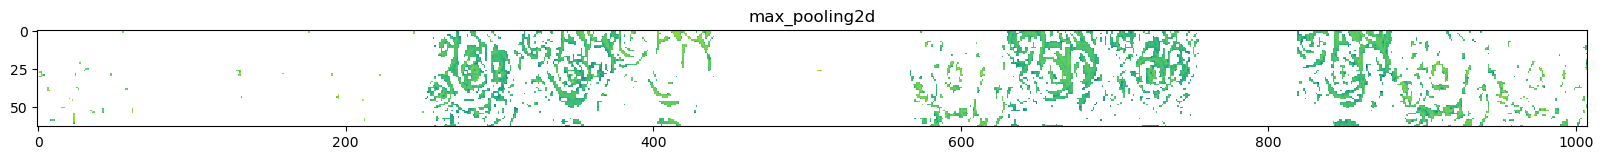

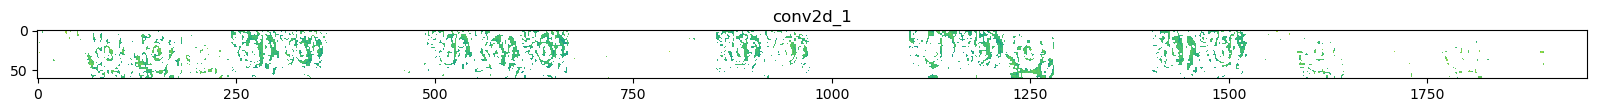

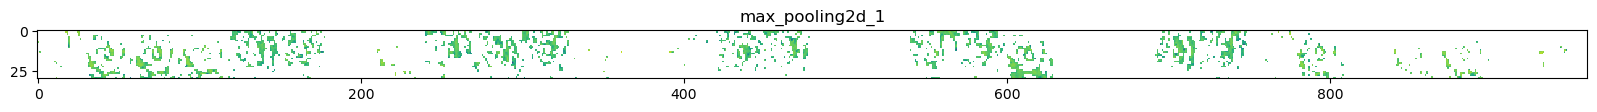

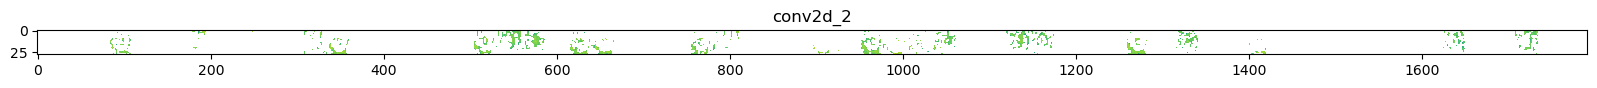

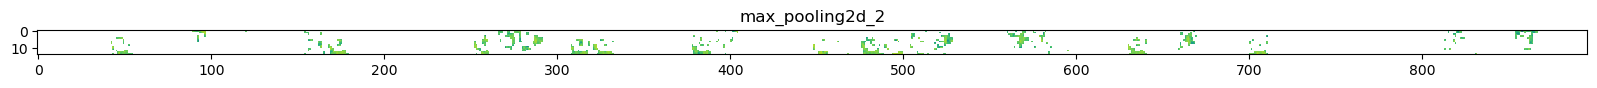

In [11]:
plot_layer_outputs(model, target_size=TARGET_SIZE)

### Overview of popular architectures

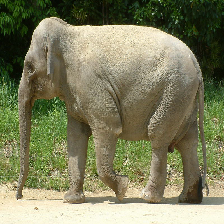

In [29]:
img_path = os.path.join(os.path.dirname(LOCAL_DATA_PATH), 'elephant.jpg')
img = load_img(img_path, target_size=(224, 224))
img

In [32]:
img_arr = img_to_array(img)
img_arr_batch = np.expand_dims(img_arr, axis=0)

#### Overview of popular architectures: ResNet50

In [33]:
model = ResNet50(weights='imagenet')
x = resnet50_preprocess_input(img_arr_batch)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', resnet50_decode_predictions(preds, top=3)[0])

2024-02-08 07:35:50.028785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 632ms/step
Predicted: [('n02504013', 'Indian_elephant', 0.81985795), ('n02504458', 'African_elephant', 0.11778743), ('n01871265', 'tusker', 0.058297556)]


#### Overview of popular architectures: VGG16

In [39]:
model = VGG16(weights='imagenet', include_top=True)
x = vgg16_preprocess_input(img_arr_batch)

preds = model.predict(x)
print('Predicted:', vgg16_decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 143ms/step
Predicted: [('n01871265', 'tusker', 0.94321245), ('n02504013', 'Indian_elephant', 0.043290593), ('n02504458', 'African_elephant', 0.013496405)]


2024-02-08 07:42:04.033517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
